# BCI Giuseppe Bonomo

In [1]:
#%%
#!git clone https://github.com/marco-siino/EEG-ATCNet.git
!pip install mne
!pip install PyWavelets
#Le ulitme versioni non sono compatibili con le librerie usate
#in preprocess_HGD.py, quindi si è optato a utilizzare una versione meno recente
!pip install braindecode==0.3

import os
import sys
import shutil
import time
import pywt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
os.chdir("/Users/giuseppebonomo/Desktop/UNIPA CdLM Ing_Informatica/Tesi/CodiceBCI/EEG-ATCNet")

import models

from preprocess import get_data
#from keras.utils.vis_utils import plot_model

# Organize the dataset.

In [2]:
# Creare la cartella "dataset" e "results" se non esistono già
os.makedirs("dataset", exist_ok=True)

#Crea la sotto-cartella train e test
os.makedirs("dataset/train", exist_ok=True)
os.makedirs("dataset/test", exist_ok=True)

In [3]:
"""#Scarico i dati di train e test per High Gamma Dataset
import os
import requests
from pathlib import Path
from tqdm import tqdm

# Definizione URL base
train_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/train"
test_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/test"

# Creazione cartelle se non esistono
train_dir = Path("dataset/train")
test_dir = Path("dataset/test")
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

def download_file(url, filepath):
    #Scarica un file con una barra di avanzamento
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        total_size = int(response.headers.get("content-length", 0))
        with open(filepath, "wb") as f, tqdm(
            desc=filepath.name, total=total_size, unit="B", unit_scale=True
        ) as bar:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
                bar.update(len(chunk))
    else:
        print(f"Errore nel download di {url}: {response.status_code}")

# Scarico i file di train e test
for i in range(1, 15):
    train_file = train_dir / f"{i}.mat"
    test_file = test_dir / f"{i}.mat"

    download_file(f"{train_url}/{i}.mat", train_file)
    download_file(f"{test_url}/{i}.mat", test_file)

print("Download completato!")
"""

'#Scarico i dati di train e test per High Gamma Dataset\nimport os\nimport requests\nfrom pathlib import Path\nfrom tqdm import tqdm\n\n# Definizione URL base\ntrain_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/train"\ntest_url = "https://gin.g-node.org/robintibor/high-gamma-dataset/raw/master/data/test"\n\n# Creazione cartelle se non esistono\ntrain_dir = Path("dataset/train")\ntest_dir = Path("dataset/test")\ntrain_dir.mkdir(parents=True, exist_ok=True)\ntest_dir.mkdir(parents=True, exist_ok=True)\n\ndef download_file(url, filepath):\n    #Scarica un file con una barra di avanzamento\n    response = requests.get(url, stream=True)\n    if response.status_code == 200:\n        total_size = int(response.headers.get("content-length", 0))\n        with open(filepath, "wb") as f, tqdm(\n            desc=filepath.name, total=total_size, unit="B", unit_scale=True\n        ) as bar:\n            for chunk in response.iter_content(chunk_size=1024):\n             

In [4]:
"""# Download the dataset BCI Competition IV 2a
base_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"
save_path = "dataset/"

for i in range(1, 10):  # Da A01 a A09
    for suffix in ["T", "E"]:  # T per training, E per evaluation
        filename = f"A{i:02d}{suffix}.mat"
        url = base_url + filename
        os.system(f"wget -O {save_path}s{i}/{filename} {url}")"""

'# Download the dataset BCI Competition IV 2a\nbase_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"\nsave_path = "dataset/"\n\nfor i in range(1, 10):  # Da A01 a A09\n    for suffix in ["T", "E"]:  # T per training, E per evaluation\n        filename = f"A{i:02d}{suffix}.mat"\n        url = base_url + filename\n        os.system(f"wget -O {save_path}s{i}/{filename} {url}")'

# Functions definitions

In [26]:
#%%
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

# Preprocessing functions definition

## DB4 (Soft -> Threshold 5.5)

In [27]:
def db4_soft(signal, wavelet='db4', level=4, threshold=5.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """


    print("Lunghezza originale:", signal.shape[-1])  # Dovrebbe essere 1125
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    print("Lunghezza coefficiente di approssimazione:", len(coeffs[0]))

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='per')
    print("Lunghezza ricostruita:", len(reconstructed_signal))

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


## DB4 (Hard -> Threshold 10.5)

In [28]:
def db4_hard(signal, wavelet='db4', level=4, threshold=10.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


## RDWT

In [29]:
import numpy as np
import scipy.signal as signal
import pywt

def rational_dilated_wavelet_transform(sig, wavelet='db4', levels=4, dilation_factors=None, threshold=5.5):
    """
    Applica la Rational Dilated Wavelet Transform (RDWT) a un segnale EEG multidimensionale.

    Args:
    - sig: array numpy di forma (eventi, 1, canali, campioni)
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - levels: numero di livelli di decomposizione (default 4)
    - dilation_factors: lista di fattori di dilatazione razionale (default: [3/2, 5/3, 7/4, ...])
    - threshold: soglia per i coefficienti di dettaglio (default 5.5)

    Returns:
    - Segnale ricostruito con la RDWT (stessa dimensione dell'input)
    """
    eventi, _, canali, campioni = sig.shape
    print("Lunghezza originale del segnale:", sig.shape)

    if dilation_factors is None:
        dilation_factors = [3/2, 5/3, 7/4, 9/5]

    coeffs_approx = sig.copy()  # Inizializza con il segnale originale
    detail_coeffs = []

    for i in range(levels):
        factor = dilation_factors[i]
        wavelet_filter = pywt.Wavelet(wavelet)
        lo_d, hi_d = wavelet_filter.dec_lo, wavelet_filter.dec_hi

        # Ridimensionamento dei filtri
        lo_d = signal.resample(lo_d, int(len(lo_d) * factor))
        hi_d = signal.resample(hi_d, int(len(hi_d) * factor))

        print(f"Livello {i+1}: coeffs_approx shape {coeffs_approx.shape}, lo_d shape {lo_d.shape}, hi_d shape {hi_d.shape}")

        approx = np.zeros_like(coeffs_approx)
        detail = np.zeros_like(coeffs_approx)

        # Applica la convoluzione per ogni canale EEG
        for e in range(eventi):
            for c in range(canali):
                approx[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], lo_d, mode='same')
                detail[e, 0, c, :] = np.convolve(coeffs_approx[e, 0, c, :], hi_d, mode='same')

                # Soglia sui coefficienti di dettaglio
                detail[e, 0, c, np.abs(detail[e, 0, c, :]) < threshold] = 0

        detail_coeffs.append(detail)
        coeffs_approx = approx  # Passa l'approssimazione al livello successivo

    # Ricostruzione del segnale
    reconstructed = coeffs_approx.copy()
    for i in range(levels-1, -1, -1):
        reconstructed += detail_coeffs[i]

    print("Lunghezza del segnale ricostruito:", reconstructed.shape)
    return reconstructed

In [30]:
def apply_preprocessing (signals_data, preprocessing):
  if preprocessing=="none":
    return signals_data
  elif preprocessing=="db4_soft":
    return db4_soft(signals_data)
  elif preprocessing=="db4_hard":
    return db4_hard(signals_data)
  elif preprocessing=="rdwt":
    return rational_dilated_wavelet_transform(signals_data)


# Model training function

In [36]:
#%% Training
from preprocess import get_data
def train(dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")

    # Get dataset parameters
    dataset = dataset_conf.get('name')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and validation data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)


        print("\n\nBefore preprocessing X_train shape is:"+str(X_train.shape))
        print("Before preprocessing X_val shape is:"+str(X_val.shape))
        
        X_train = apply_preprocessing(X_train, preprocessing=signal_preprocessing)
        X_val = apply_preprocessing(X_val, preprocessing=signal_preprocessing)
        
        X_train = X_train[:,:,:44,:1125]
        X_val = X_val[:,:,:44,:1125]
        print("\n\nAfter preprocessing X_train shape is:"+str(X_train.shape))
        print("After preprocessing X_val shape is:"+str(X_val.shape))


        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.weights.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()


# Evaluation function

In [37]:
#%% Evaluation
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    signal_preprocessing = dataset_conf.get('signal_preprocessing')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
    #Ripetuto
    #signal_preprocessing = dataset_conf.get('signal_preprocessing')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        X_test = apply_preprocessing(X_test, preprocessing=signal_preprocessing)
        X_test = X_test[:,:,:44,:1125]

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.weights.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()

# Model selection and setup

In [38]:
#%%
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'RockNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.RockNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

# Run the simulation

## Define the run function.

In [39]:
#%%
def run(signal_preprocessing):
    # Define dataset parameters
    #dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'
    dataset = 'HGD'

    if dataset == 'BCI2a':
        in_samples = 1125
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
        data_path = 'dataset/' #os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    elif dataset == 'HGD':
        #print("Dataset scelto:",dataset)
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
        data_path = 'dataset/' #os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
        #print("Data path:",data_path)
    elif dataset == 'CS2R':
        in_samples = 1125
        # in_samples = 576
        n_channels = 32
        n_sub = 18
        n_classes = 3
        # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']
        classes_labels = ['Fingers', 'Wrist','Elbow']
        # classes_labels = ['Fingers', 'Elbow']
        data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/results"
    if not  os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist

    # Set dataset paramters
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False,
                     'signal_preprocessing':signal_preprocessing}

    # Set training hyperparamters
    train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'RockNet'}

    # Train the model
    print("Training the model...")
    train(dataset_conf, train_conf, results_path)
    print("Training completed!")

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
    test(model, dataset_conf, results_path)


Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 1225545)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 320
Durate degli eventi: [ 3725  3510  3705  3790  3545  3625  3650  3555  3815  3660  3990  3965
  3830  3825  3755  3850  3530  3865  3865  3585  3895  3520  3850  3555
  3790  3765  3855  3585  3875  3500  3880  3805  3545  3610  3535  3620
  3835  3

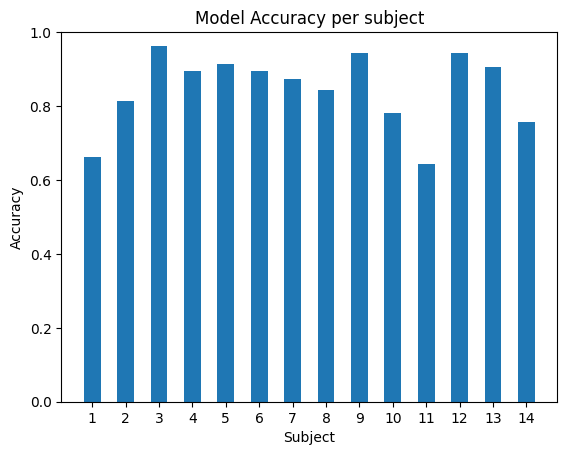

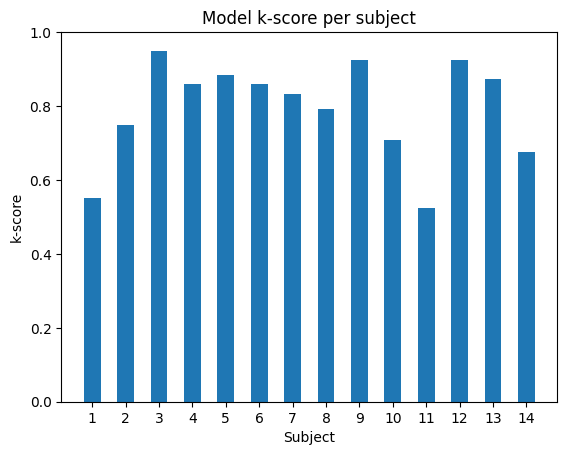

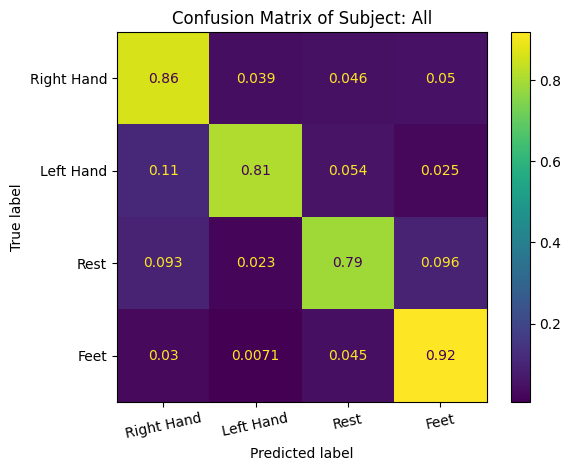

In [34]:
#Testo sui dati di test
# Set dataset paramters

dataset = 'HGD'
in_samples = 1125
n_channels = 44
n_sub = 14
n_classes = 4
classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
data_path = 'dataset/' 
signal_preprocessing = "none"

results_path = "/Users/giuseppebonomo/Desktop/UNIPA CdLM Ing_Informatica/Tesi/CodiceBCI/EEG-ATCNet/results"
        
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False,
                     'signal_preprocessing':signal_preprocessing}

# Set training hyperparamters
train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'RockNet'}

model = getModel(train_conf.get('model'), dataset_conf)
test(model, dataset_conf, results_path)

## No preprocessing on EEG.

Training the model...

Training on subject  1
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 1225545)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 320
Durate degli eventi: [ 3725  3510  3705  3790  3545  3625  3650  3555  3815  3660  3990  3965
  3830  3825  3755  3850  3530  3865  3865  3585  3895  3520  3850  3555
  3790  3765  3855  3585  3875  3500

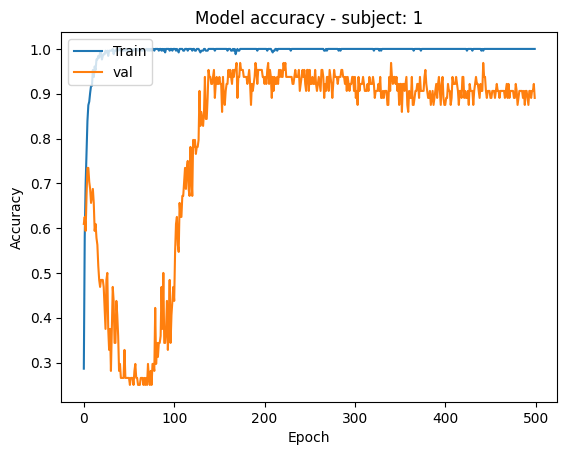

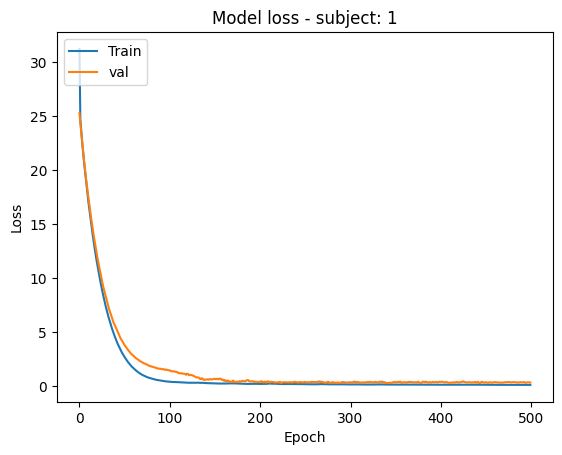


Training on subject  2
Creating RawArray with float64 data, n_channels=128, n_times=3131420
    Range : 0 ... 3131419 =      0.000 ...  6262.838 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3131420)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
813 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 813
Durate degli eventi: [ 3765  3610  3970  3950  3620  3810  3880  3750  3860  3640  3990  3750
  3840  3555  3695  3985  3895  3900  3675  3520  3700  3640  3855  3680
  3890  3565  3590  3575  3655  3965  3645  4000  3915  37

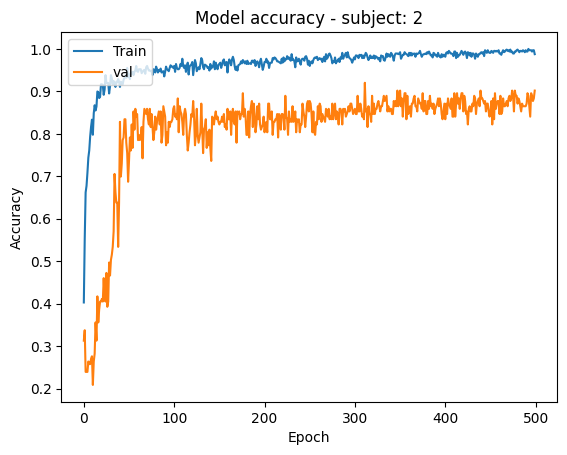

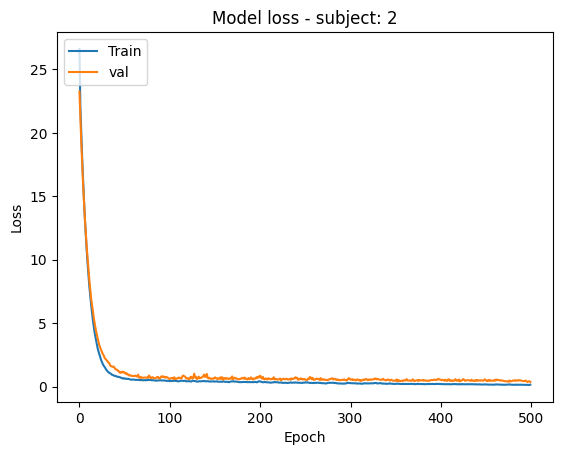


Training on subject  3
Creating RawArray with float64 data, n_channels=128, n_times=3347155
    Range : 0 ... 3347154 =      0.000 ...  6694.308 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3347155)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [3500 3935 3895 3835 3915 3685 3805 3905 3975 3630 4000 3650 3530 3845
 3850 3940 3975 3720 3530 3685 3945 3690 3920 3510 3550 3805 3840 3815
 3845 3910 3615 3525 3925 3590 3835 3855 3770 3815 3885 3850 3

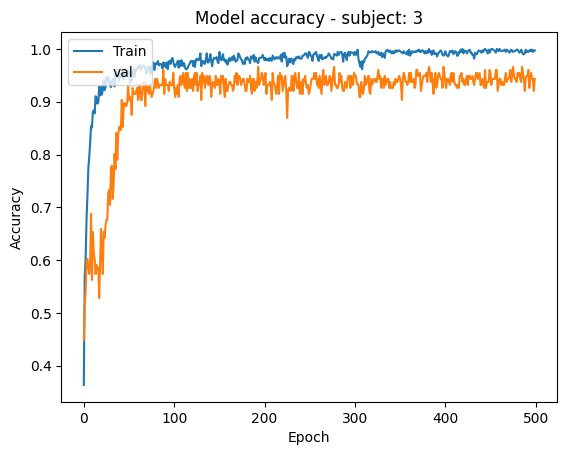

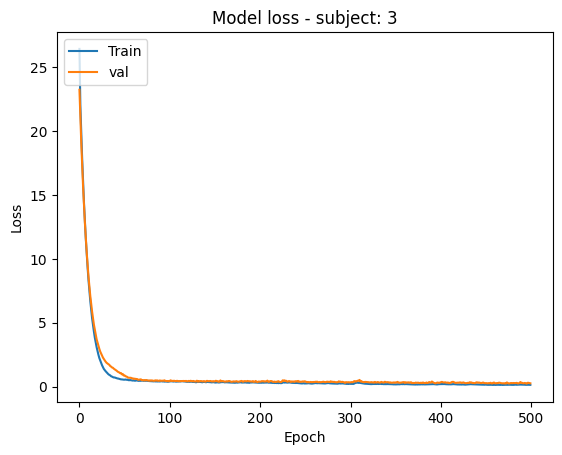


Training on subject  4
Creating RawArray with float64 data, n_channels=128, n_times=3451320
    Range : 0 ... 3451319 =      0.000 ...  6902.638 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3451320)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
897 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 897
Durate degli eventi: [ 3680  3725  3620  3885  3790  3585  3660  3640  3880  3565  3995  3520
  3975  3520  3650  3585  3700  3665  3505  3985  3860  3890  3670  3740
  3675  3830  3995  3690  3520  3955  3935  3580  3835  39

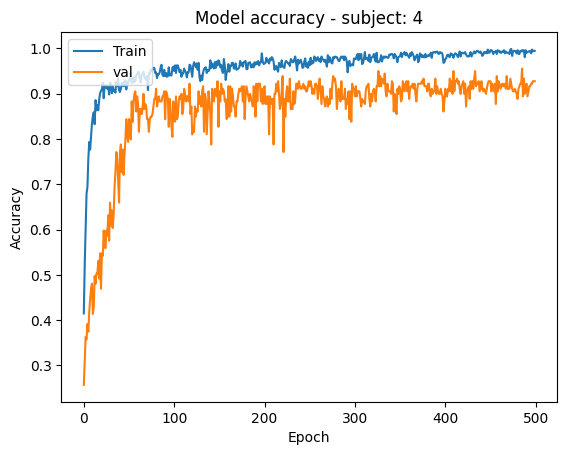

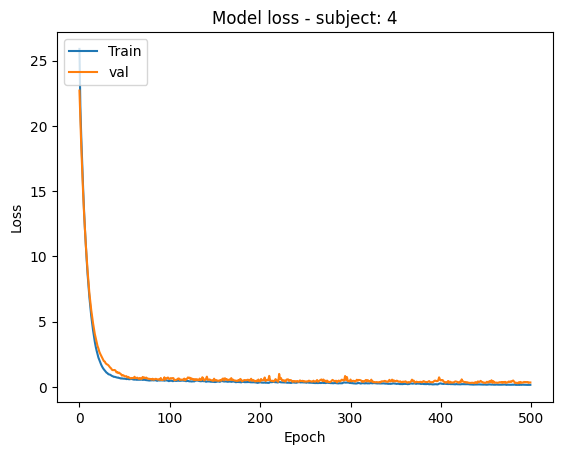


Training on subject  5
Creating RawArray with float64 data, n_channels=128, n_times=2736300
    Range : 0 ... 2736299 =      0.000 ...  5472.598 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 2736300)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
720 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 720
Durate degli eventi: [3740 3800 3525 3635 3775 3825 3990 3860 3735 3870 3790 3660 3580 3965
 3870 3820 3825 3540 3725 3720 3740 3840 3755 4000 3890 3585 3740 3820
 3545 3645 3690 3810 3830 3540 3900 3810 3915 3855 3615 3820 3

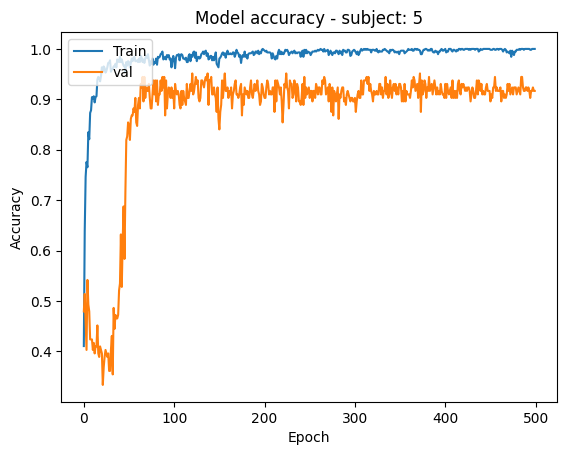

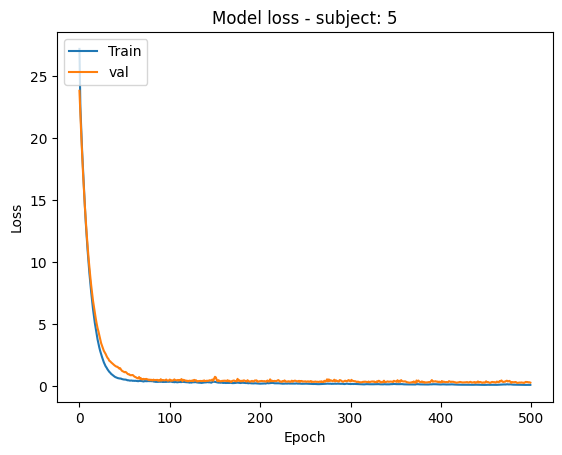


Training on subject  6
Creating RawArray with float64 data, n_channels=128, n_times=3387290
    Range : 0 ... 3387289 =      0.000 ...  6774.578 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3387290)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [ 3730  3525  3860  3950  3965  3940  3720  3860  3995  3620  3500  3685
  3665  3920  3940  3760  3795  3840  3940  3685  3585  3655  3610  3845
  3885  3820  3900  3675  3790  3845  3695  3955  3975  38

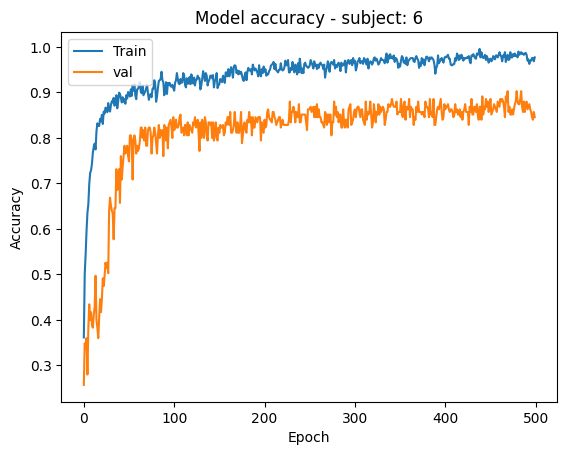

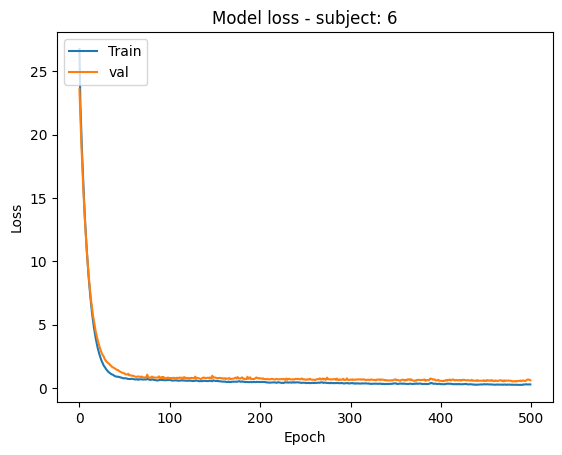


Training on subject  7
Creating RawArray with float64 data, n_channels=128, n_times=3354460
    Range : 0 ... 3354459 =      0.000 ...  6708.918 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3354460)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [3940 3875 3900 3915 3565 3760 3680 3730 3555 3535 3850 3725 3665 3560
 3545 3950 3695 3590 3955 3825 3820 3505 3905 3805 3620 3565 3965 3560
 3575 3520 3875 3640 3710 3705 3575 3630 3905 3695 3995 3655 3

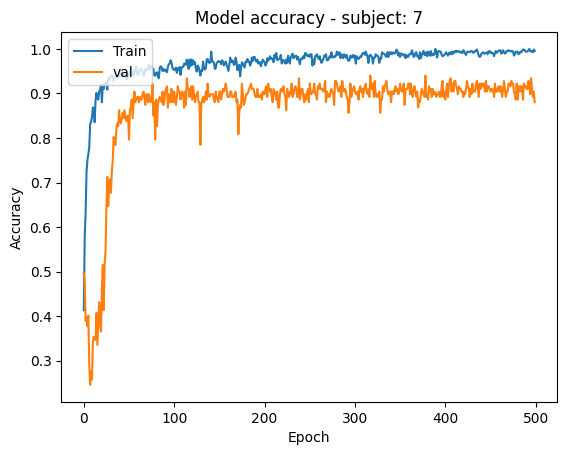

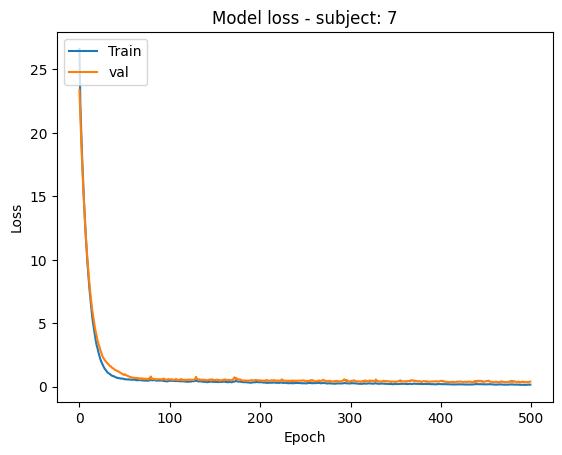


Training on subject  8
Creating RawArray with float64 data, n_channels=128, n_times=2511860
    Range : 0 ... 2511859 =      0.000 ...  5023.718 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 2511860)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
654 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 654
Durate degli eventi: [ 3630  3690  3875  3625  3660  3960  3745  3580  3530  3915  4000  3670
  3670  3750  3655  3635  3575  3715  3580  3650  3510  3880  3930  3735
  3880  3820  3930  3590  3820  3585  3985  3725  3945  39

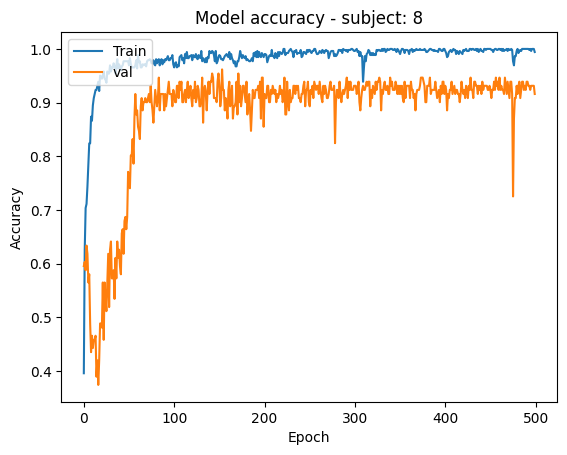

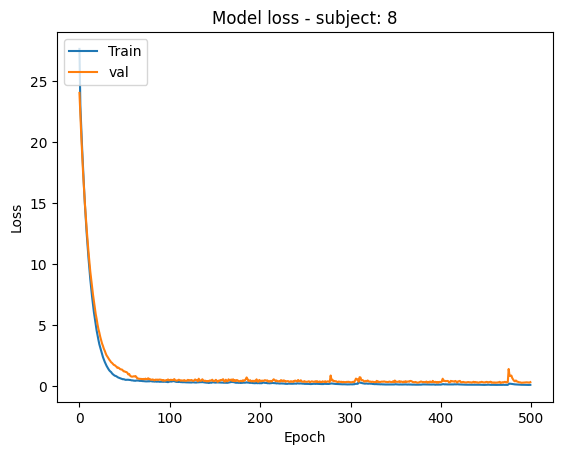


Training on subject  9
Creating RawArray with float64 data, n_channels=128, n_times=3383655
    Range : 0 ... 3383654 =      0.000 ...  6767.308 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3383655)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [ 3965  3890  3605  3630  3535  3575  3500  3885  3645  3875  3880  3870
  3825  3720  3740  3620  3770  4000  3830  3750  3570  3890  3615  3910
  3695  3645  3950  3870  3650  3810  3690  3585  3690  38

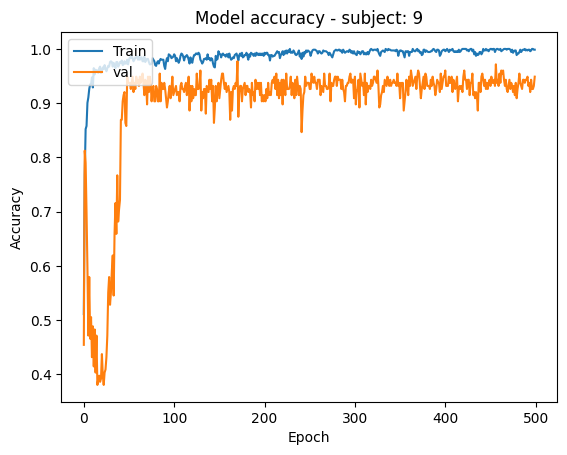

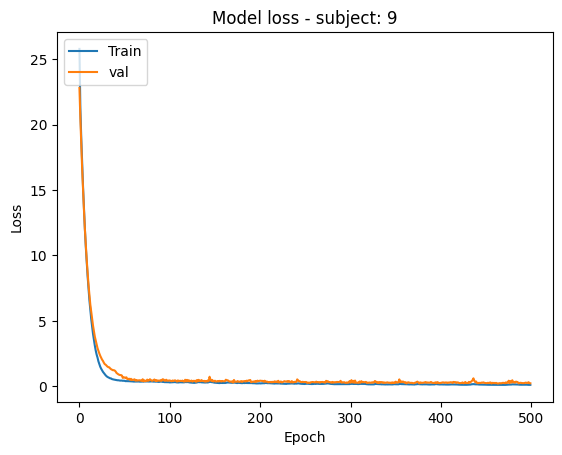


Training on subject  10
Creating RawArray with float64 data, n_channels=128, n_times=3386150
    Range : 0 ... 3386149 =      0.000 ...  6772.298 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3386150)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [ 3985  3785  3815  3995  3505  3590  3885  3715  3700  3915  3595  3870
  4000  3595  3845  3805  3925  3915  3590  3540  3760  3830  3615  3710
  3825  3790  3925  3560  3605  3980  3570  3935  3510  3

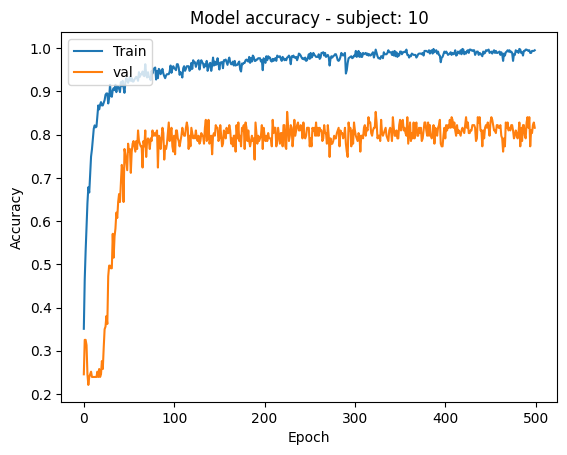

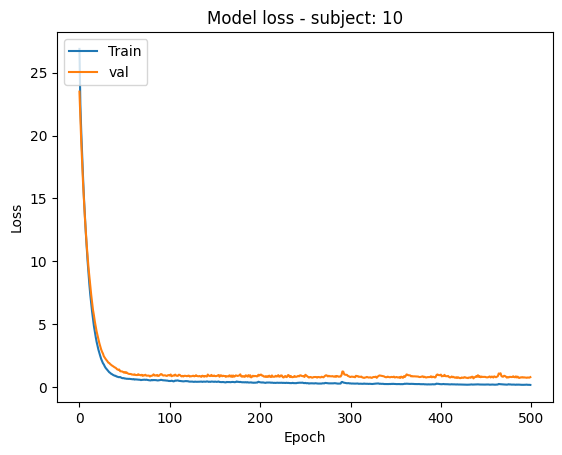


Training on subject  11
Creating RawArray with float64 data, n_channels=128, n_times=3386765
    Range : 0 ... 3386764 =      0.000 ...  6773.528 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3386765)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [ 3680  3505  3755  3620  3850  3955  3795  3760  3670  3545  3630  3515
  3645  3730  3715  3580  3830  3670  3640  3750  3850  3840  3805  3655
  3885  3780  3570  3885  3930  3620  3515  3855  3760  3

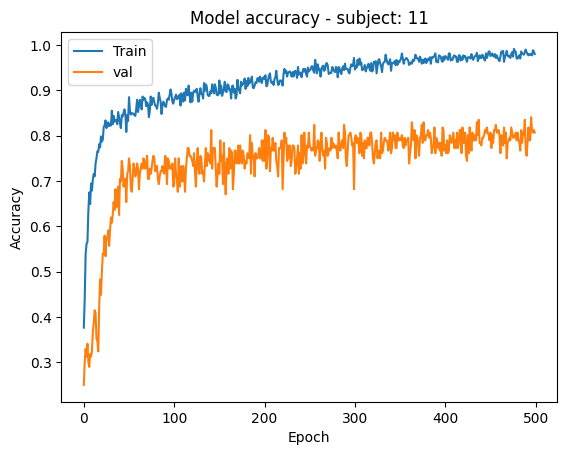

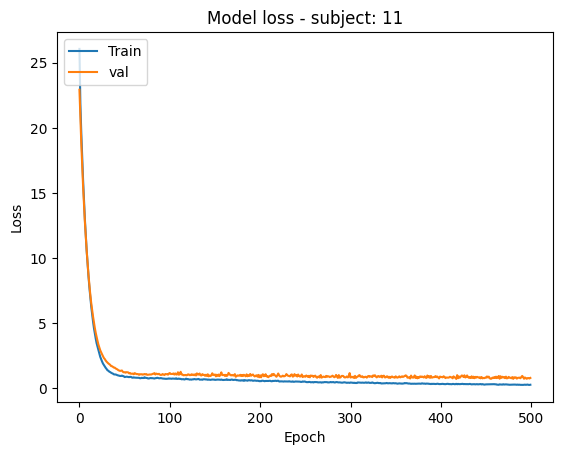


Training on subject  12
Creating RawArray with float64 data, n_channels=128, n_times=3385750
    Range : 0 ... 3385749 =      0.000 ...  6771.498 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3385750)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [ 3740  3525  3705  3505  3540  3605  3575  3955  3805  3990  3840  3785
  3700  3890  3965  4000  3875  3675  3550  3870  3510  3835  3745  3605
  3830  3755  3805  3950  3925  3835  3560  3820  3645  3

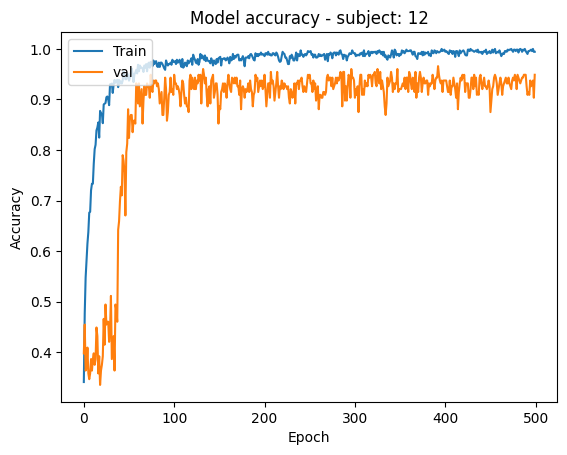

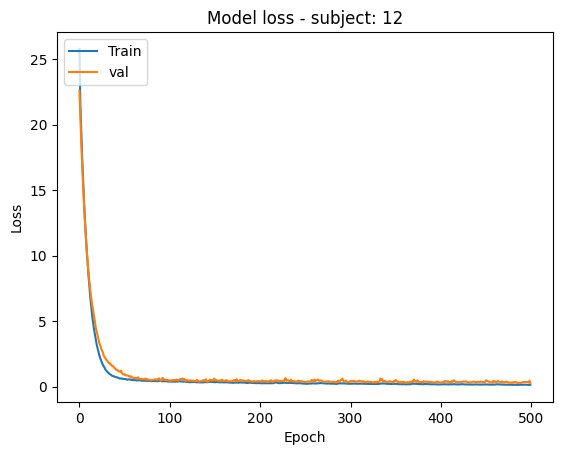


Training on subject  13
Creating RawArray with float64 data, n_channels=128, n_times=3032845
    Range : 0 ... 3032844 =      0.000 ...  6065.688 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3032845)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
800 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 800
Durate degli eventi: [3680 3965 3630 3575 3735 3865 3515 3980 3620 3670 3985 3700 3575 3900
 3850 3870 3730 3940 3505 3615 3980 3625 3985 3630 3765 3855 3645 3805
 3960 3935 3620 3560 3580 3625 3820 3610 3795 3815 3530 3850 

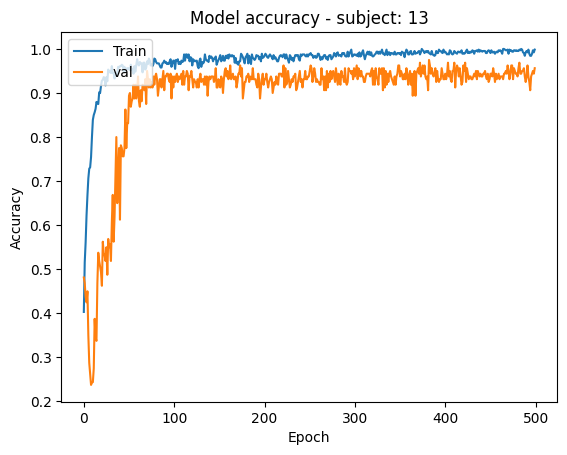

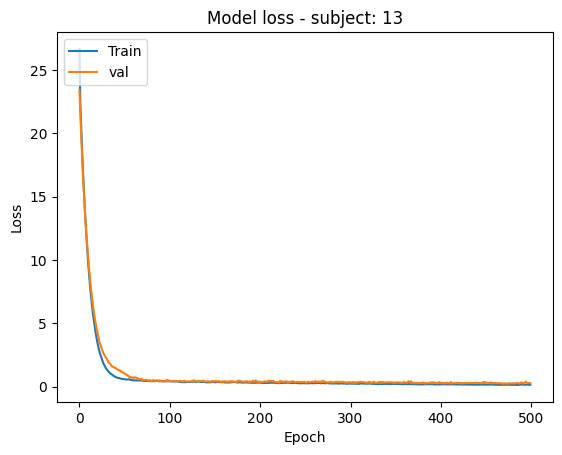


Training on subject  14
Creating RawArray with float64 data, n_channels=128, n_times=3345425
    Range : 0 ... 3345424 =      0.000 ...  6690.848 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 3345425)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Tempo di un campione: 0.002
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di eventi: 880
Durate degli eventi: [3645 3695 3990 3845 3825 3790 3935 3930 3730 3775 3890 3965 3595 3995
 3725 3685 3760 3920 3880 3645 3675 3715 3630 3925 3915 3725 3645 3830
 3745 3700 3825 3790 3520 3915 3810 3725 3705 3805 3540 3550 

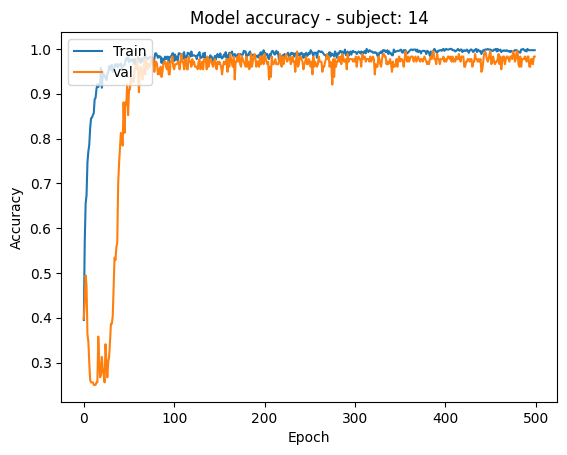

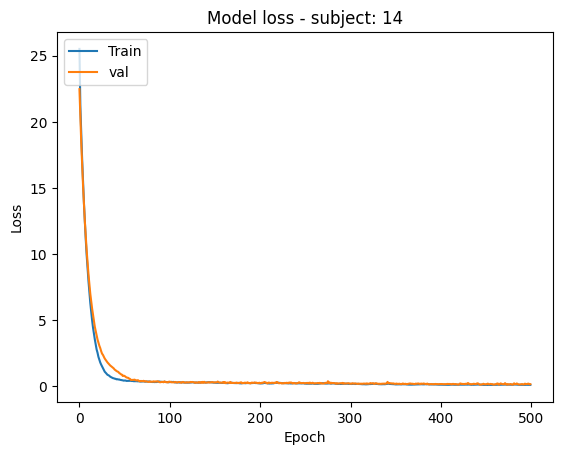


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9   sub_10   sub_11   sub_12   sub_13   sub_14     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  96.88   88.96   95.45   95.53   92.36   90.29   92.22   94.66   95.45   84.05   81.25   94.89   96.25   99.43     92.69   
---------------------------------
Average acc - all seeds: 92.69 %

Train Time  - all seeds: 1484.2 min
---------------------------------

Training completed!
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 1225545)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/giuseppebonomo/Desktop/UNIPA CdLM Ing_Informatica/Tesi/CodiceBCI/EEG-ATCNet/results/saved models/run-1/subject-1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [29]:
run("none")

## DB4 (Soft) Preprocessing.

In [40]:
run("db4_soft")

Training the model...

Training on subject  1
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=616535
    Range : 0 ... 616534 =      0.000 ...  1233.068 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(255, 1, 45, 2250)
Before preprocessing X_val shape is:(64, 1, 45, 2250)
Lunghez

KeyboardInterrupt: 

## DB4 (Hard) Preprocessing.

Training the model...
Dataset:  HGD
Number of subjects:  14
Data path:  dataset/
Standardization:  True
Leave-one-subject-out:  False

Training on subject  1
Sto per chiamare get_data
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dati grezzi CST_raw_mne: (129, 1225545)
RAW:  <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fpz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 128 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>
ANNOTAIONS: <Annotations | 0 segments>
Valori unici nel canale di Stimulus: [0. 2. 4. 6. 8.]
Valori unici nel canale di Stimulus che ti interessano: [2.0, 4.0, 6.0]
Tempo di un campione: 0.002
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Numero di event

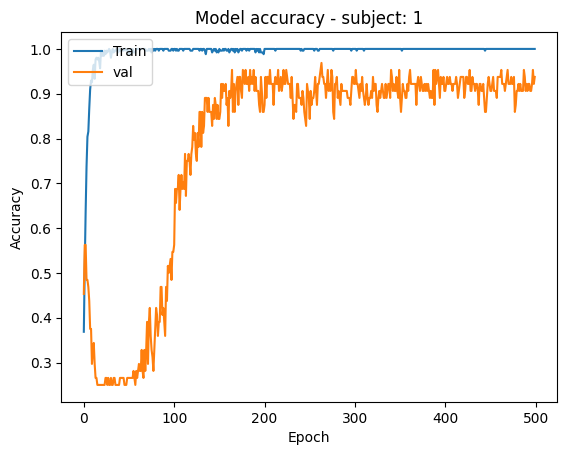

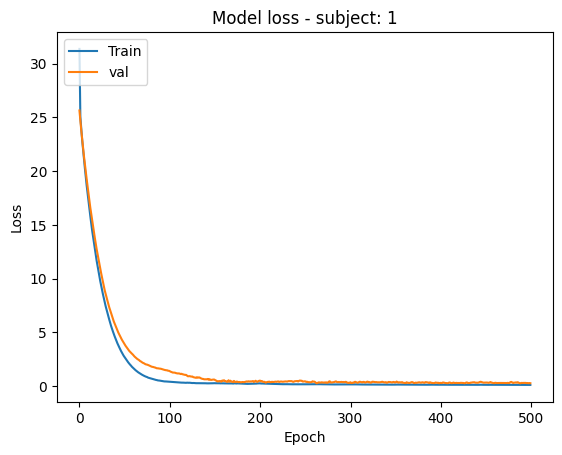


Training on subject  2
Sto per chiamare get_data
Creating RawArray with float64 data, n_channels=128, n_times=3131420
    Range : 0 ... 3131419 =      0.000 ...  6262.838 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


KeyboardInterrupt: 

In [ ]:
run("db4_hard")

## RDWT

Training the model...

Training on subject  1
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=616535
    Range : 0 ... 616534 =      0.000 ...  1233.068 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(255, 1, 45, 2250)
Before preprocessing X_val shape is:(64, 1, 45, 2250)
Lunghez

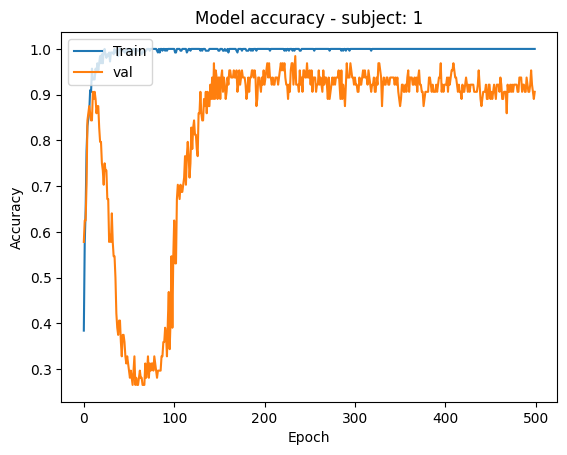

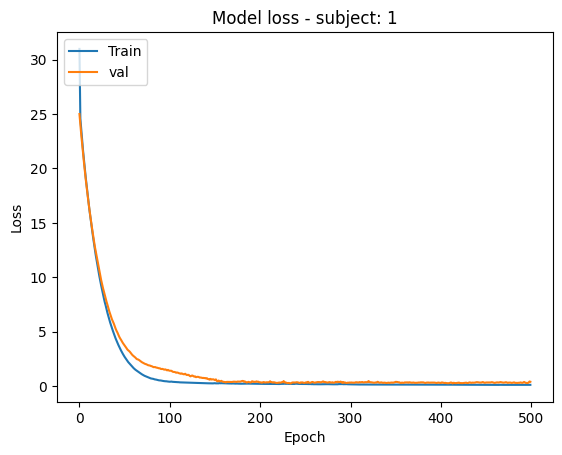


Training on subject  2
Creating RawArray with float64 data, n_channels=128, n_times=3131420
    Range : 0 ... 3131419 =      0.000 ...  6262.838 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
813 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
813 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=614290
    Range : 0 ... 614289 =      0.000 ...  1228.578 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(648, 1, 45, 2250)
Before preprocessing X_val shape is:(163, 1, 45, 2250)
Lunghezza originale del segn

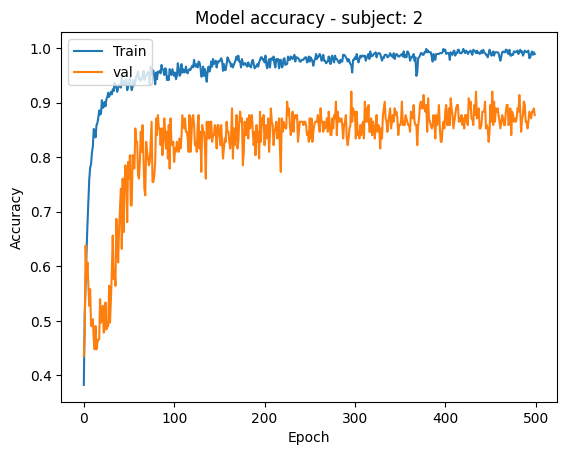

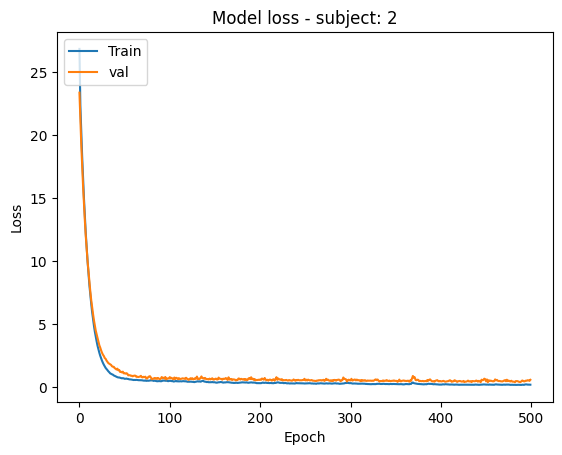


Training on subject  3
Creating RawArray with float64 data, n_channels=128, n_times=3347155
    Range : 0 ... 3347154 =      0.000 ...  6694.308 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=609030
    Range : 0 ... 609029 =      0.000 ...  1218.058 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(704, 1, 45, 2250)
Before preprocessing X_val shape is:(176, 1, 45, 2250)
Lunghezza originale del segn

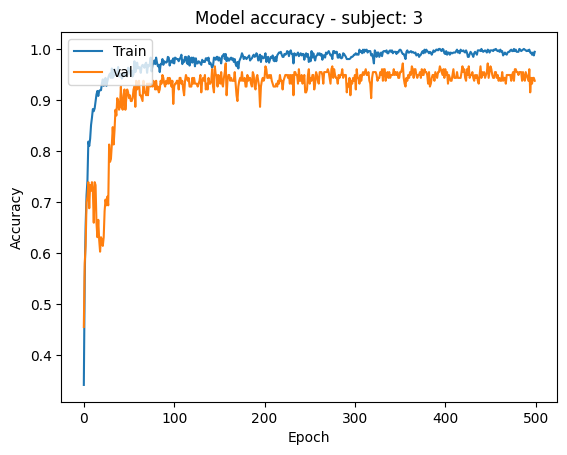

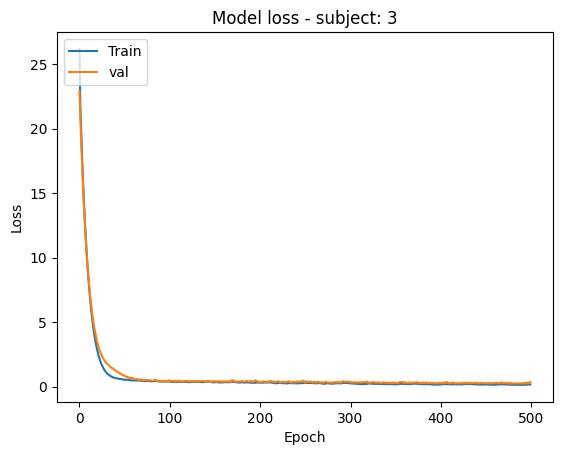


Training on subject  4
Creating RawArray with float64 data, n_channels=128, n_times=3451320
    Range : 0 ... 3451319 =      0.000 ...  6902.638 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
897 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
897 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=617090
    Range : 0 ... 617089 =      0.000 ...  1234.178 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(716, 1, 45, 2250)
Before preprocessing X_val shape is:(179, 1, 45, 2250)
Lunghezza originale del segn

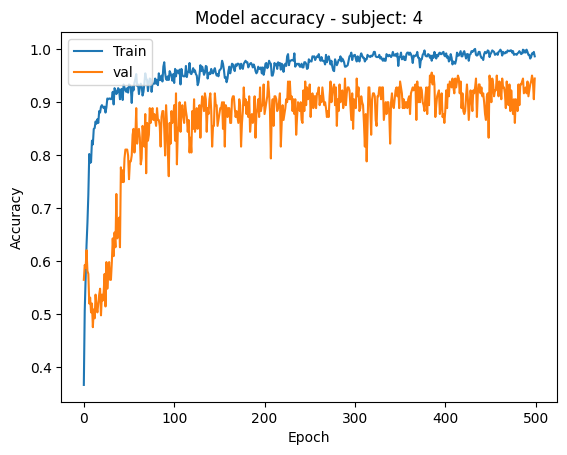

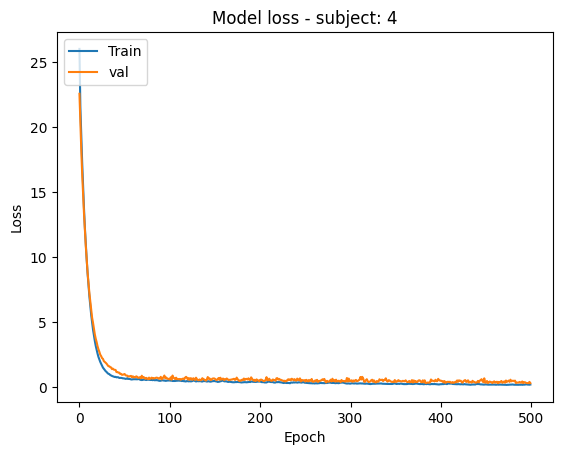


Training on subject  5
Creating RawArray with float64 data, n_channels=128, n_times=2736300
    Range : 0 ... 2736299 =      0.000 ...  5472.598 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
720 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
720 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=607250
    Range : 0 ... 607249 =      0.000 ...  1214.498 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(575, 1, 45, 2250)
Before preprocessing X_val shape is:(144, 1, 45, 2250)
Lunghezza originale del segn

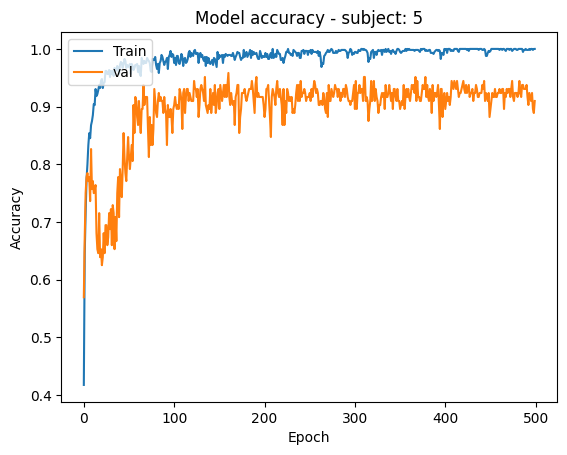

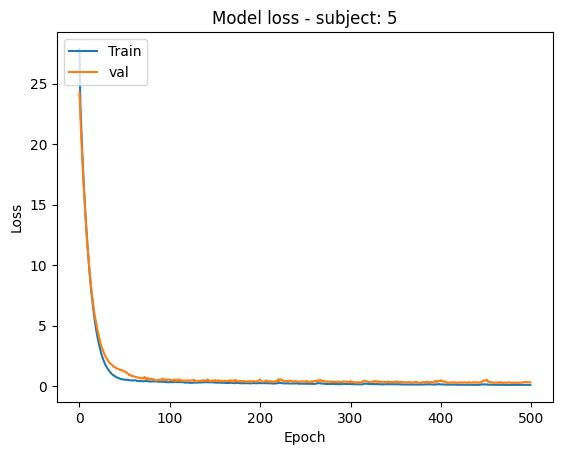


Training on subject  6
Creating RawArray with float64 data, n_channels=128, n_times=3387290
    Range : 0 ... 3387289 =      0.000 ...  6774.578 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=615705
    Range : 0 ... 615704 =      0.000 ...  1231.408 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(697, 1, 45, 2250)
Before preprocessing X_val shape is:(175, 1, 45, 2250)
Lunghezza originale del segn

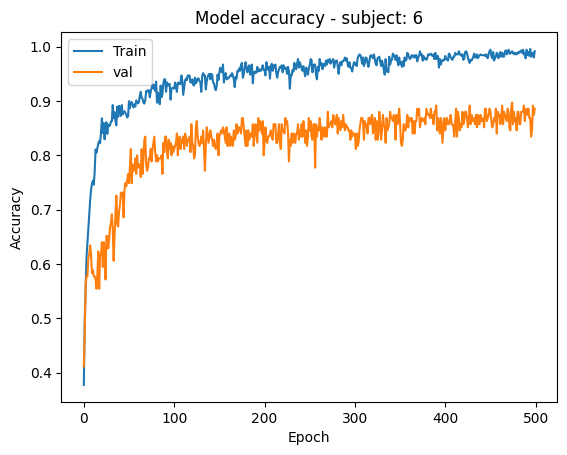

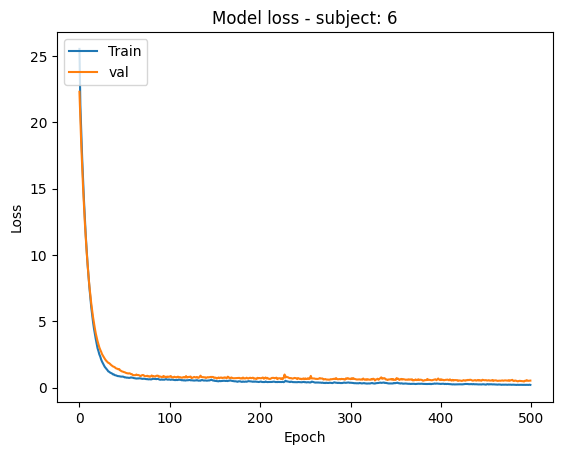


Training on subject  7
Creating RawArray with float64 data, n_channels=128, n_times=3354460
    Range : 0 ... 3354459 =      0.000 ...  6708.918 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=608850
    Range : 0 ... 608849 =      0.000 ...  1217.698 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(668, 1, 45, 2250)
Before preprocessing X_val shape is:(167, 1, 45, 2250)
Lunghezza originale del segn

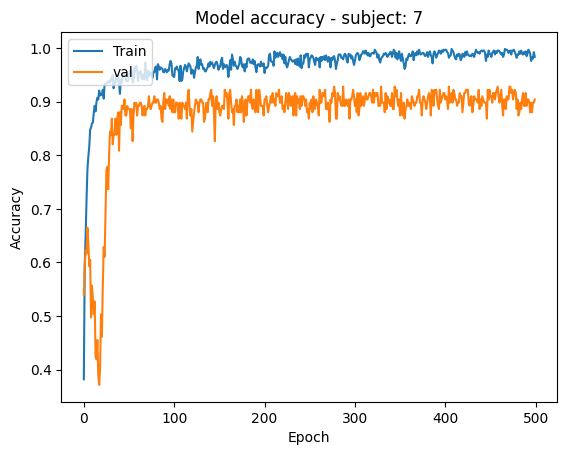

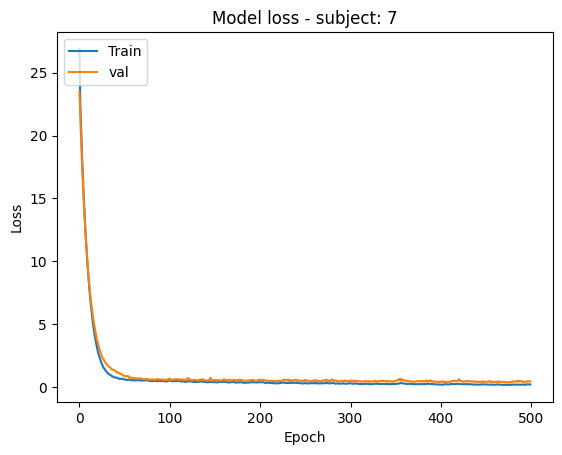


Training on subject  8
Creating RawArray with float64 data, n_channels=128, n_times=2511860
    Range : 0 ... 2511859 =      0.000 ...  5023.718 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
654 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
654 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=616070
    Range : 0 ... 616069 =      0.000 ...  1232.138 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(523, 1, 45, 2250)
Before preprocessing X_val shape is:(131, 1, 45, 2250)
Lunghezza originale del segn

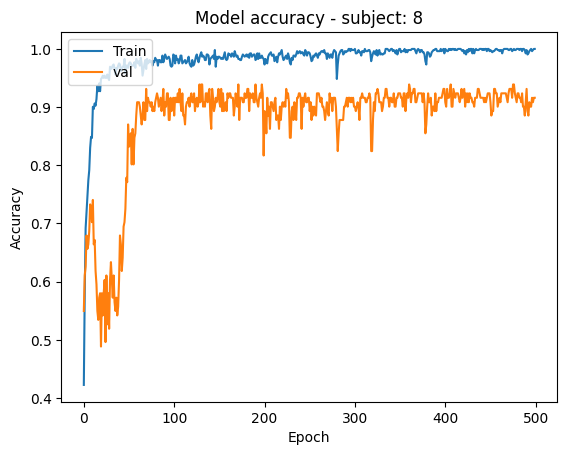

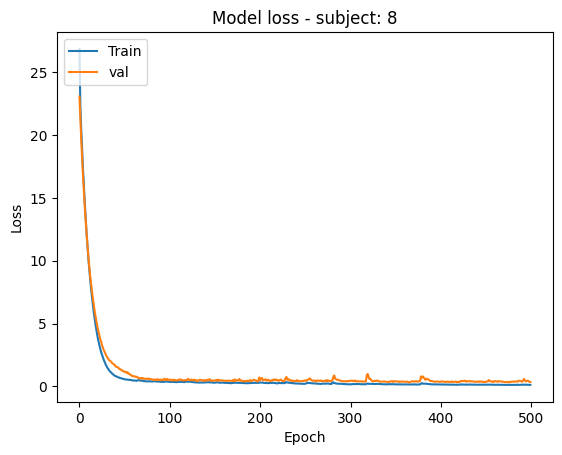


Training on subject  9
Creating RawArray with float64 data, n_channels=128, n_times=3383655
    Range : 0 ... 3383654 =      0.000 ...  6767.308 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=614600
    Range : 0 ... 614599 =      0.000 ...  1229.198 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(704, 1, 45, 2250)
Before preprocessing X_val shape is:(176, 1, 45, 2250)
Lunghezza originale del segn

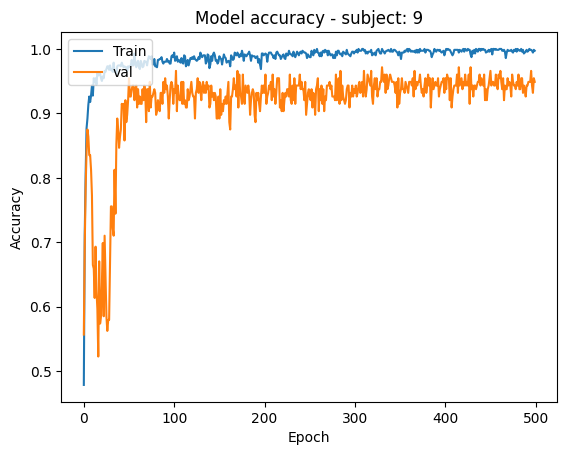

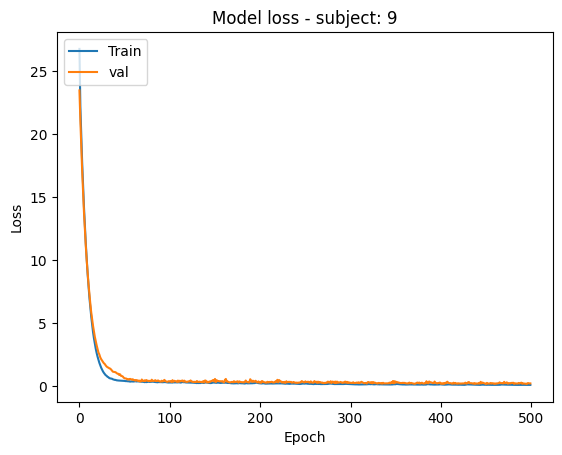


Training on subject  10
Creating RawArray with float64 data, n_channels=128, n_times=3386150
    Range : 0 ... 3386149 =      0.000 ...  6772.298 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=614555
    Range : 0 ... 614554 =      0.000 ...  1229.108 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(650, 1, 45, 2250)
Before preprocessing X_val shape is:(163, 1, 45, 2250)
Lunghezza originale del seg

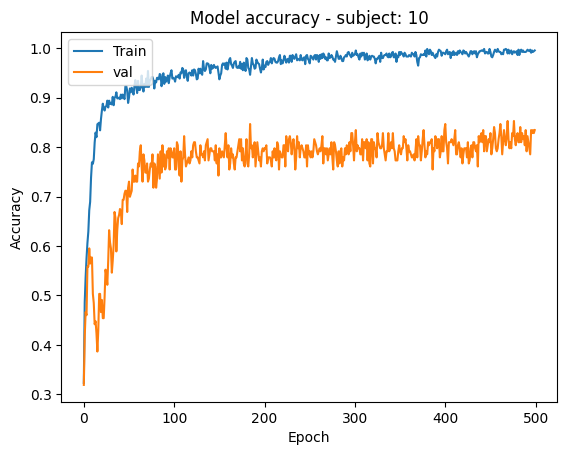

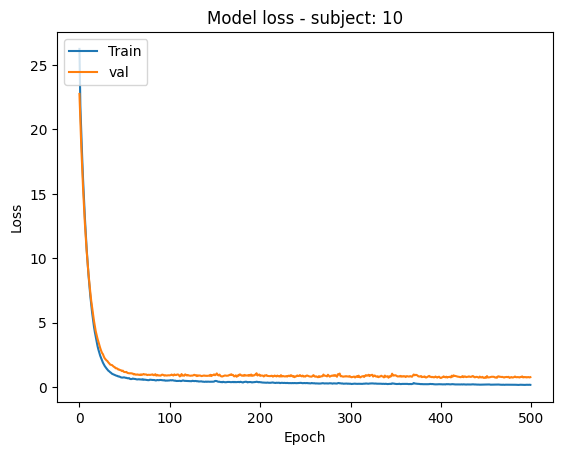


Training on subject  11
Creating RawArray with float64 data, n_channels=128, n_times=3386765
    Range : 0 ... 3386764 =      0.000 ...  6773.528 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=610820
    Range : 0 ... 610819 =      0.000 ...  1221.638 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(704, 1, 45, 2250)
Before preprocessing X_val shape is:(176, 1, 45, 2250)
Lunghezza originale del seg

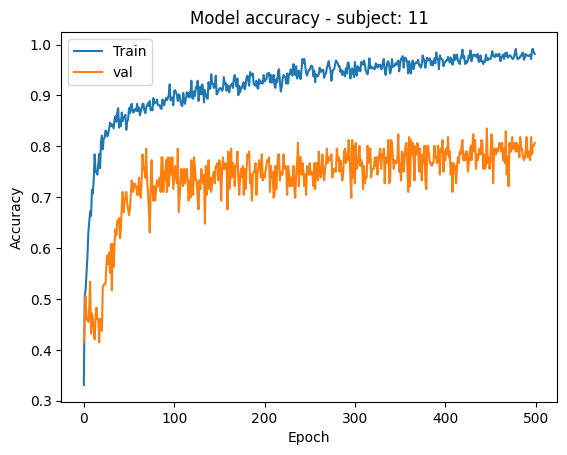

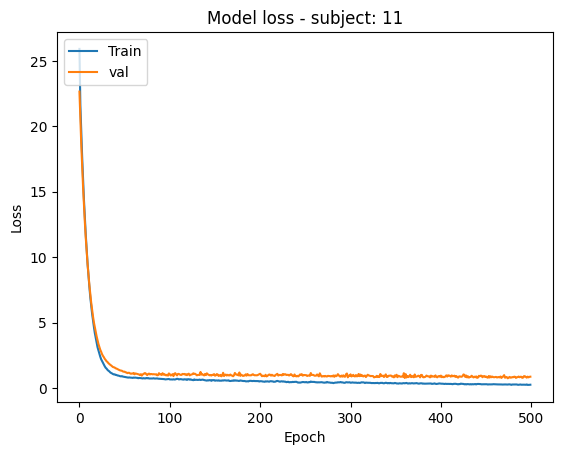


Training on subject  12
Creating RawArray with float64 data, n_channels=128, n_times=3385750
    Range : 0 ... 3385749 =      0.000 ...  6771.498 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=617735
    Range : 0 ... 617734 =      0.000 ...  1235.468 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(701, 1, 45, 2250)
Before preprocessing X_val shape is:(176, 1, 45, 2250)
Lunghezza originale del seg

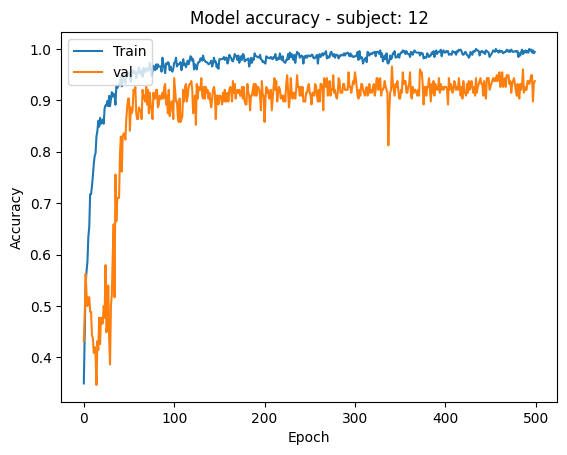

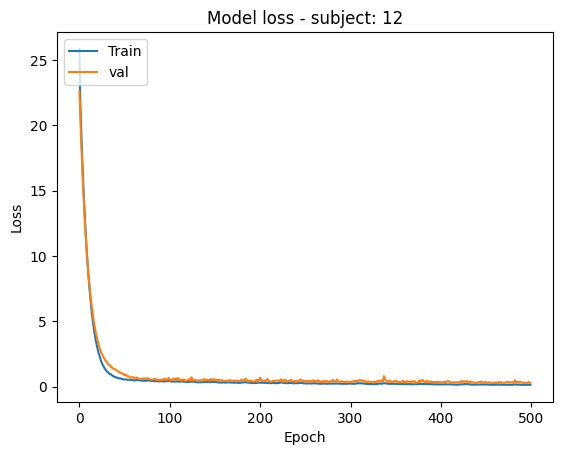


Training on subject  13
Creating RawArray with float64 data, n_channels=128, n_times=3032845
    Range : 0 ... 3032844 =      0.000 ...  6065.688 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
800 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
800 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=607735
    Range : 0 ... 607734 =      0.000 ...  1215.468 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(640, 1, 45, 2250)
Before preprocessing X_val shape is:(160, 1, 45, 2250)
Lunghezza originale del seg

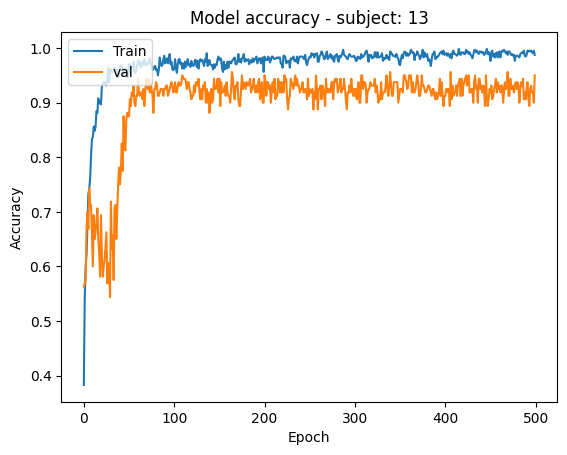

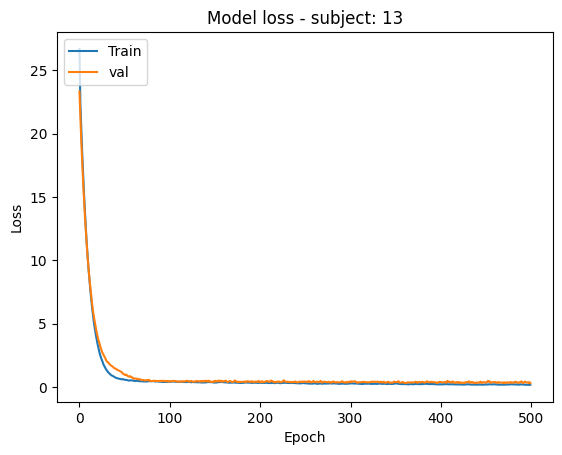


Training on subject  14
Creating RawArray with float64 data, n_channels=128, n_times=3345425
    Range : 0 ... 3345424 =      0.000 ...  6690.848 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
880 events found on stim channel STI 014
Event IDs: [2 4 6 8]
Creating RawArray with float64 data, n_channels=128, n_times=608505
    Range : 0 ... 608504 =      0.000 ...  1217.008 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
160 events found on stim channel STI 014
Event IDs: [2 4 6 8]


Before preprocessing X_train shape is:(704, 1, 45, 2250)
Before preprocessing X_val shape is:(176, 1, 45, 2250)
Lunghezza originale del seg

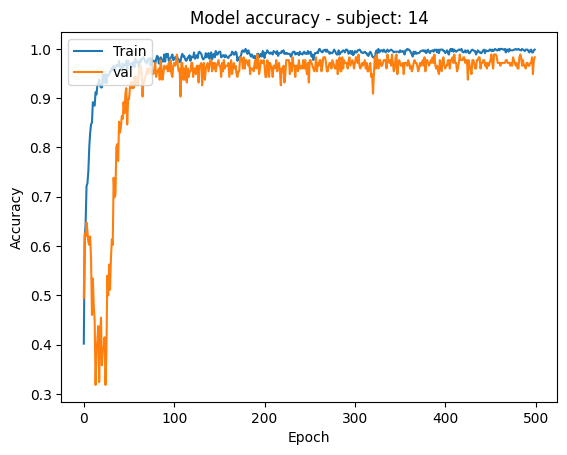

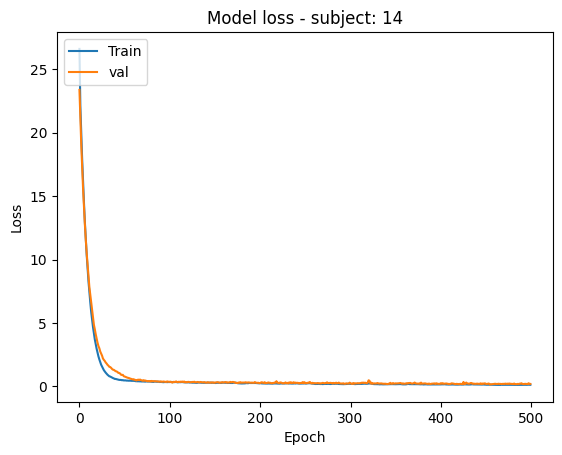


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9   sub_10   sub_11   sub_12   sub_13   sub_14     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  98.44   90.18   96.02   94.41   92.36   88.57   92.22   93.13   96.59   84.66   81.82   95.45   94.38   98.86     92.65   
---------------------------------
Average acc - all seeds: 92.65 %

Train Time  - all seeds: 1479.6 min
---------------------------------

Training completed!
Creating RawArray with float64 data, n_channels=128, n_times=1225545
    Range : 0 ... 1225544 =      0.000 ...  2451.088 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
320 events found on stim channel STI 014
Event IDs: [2 4 6 8]
NOTE: pick_channels() is a legacy function. New code should use i

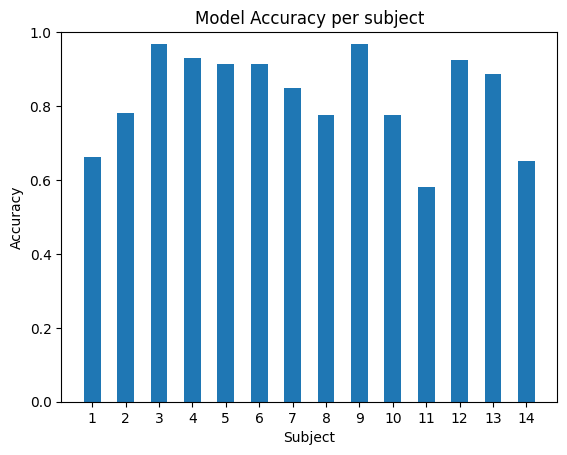

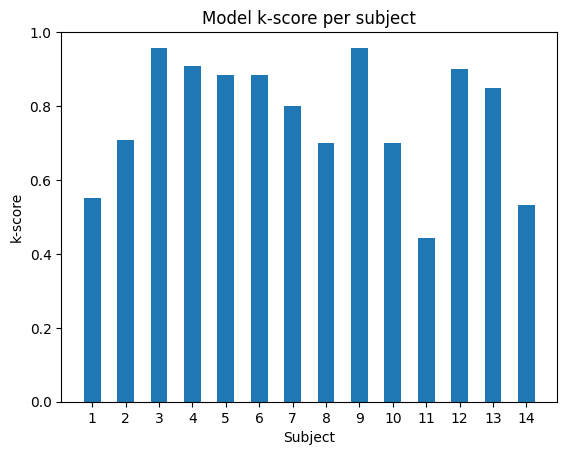

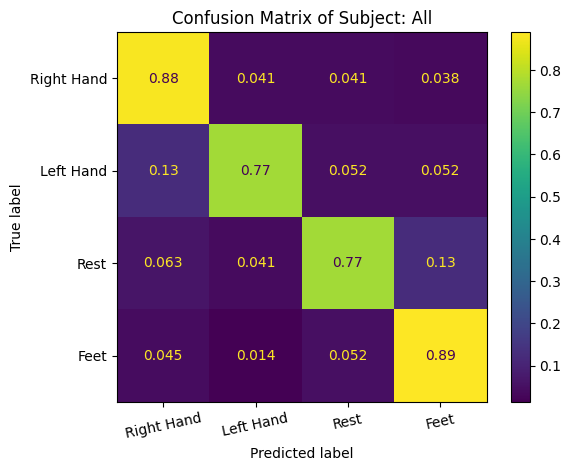

In [25]:
run("rdwt")